In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import linregress
from math import factorial

from scipy.stats import lognorm, poisson, gamma

#from scipy.stats import bootstrap

import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['savefig.dpi'] = 300

mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 30

def compute_P0(λ, μ, p, M):
    
    P0 = 1
    
    for i in range(1, M):
        
        P0 += (λ/μ)**i / factorial(i)
        
    P0 += ( ((λ/μ)**M / factorial(M)) * (1/1-p) )
    
    P0 = 1 / P0
    
    return P0

def tiempo_medio_cola_CRA(λ, μ, p, M, P0):

    return (P0*(λ/μ)**M*p) / (λ * factorial(M)*(1-p)**2)

def tiempo_medio_cola_OAO(N_PHD, M, t_h):
    
    return ((N_PHD/M - 1) / 2) * t_h

def wasted_papers(wasted_hours, papers_phd_hour, N_PHD):
    
    return papers_phd_hour * N_PHD * wasted_hours

def wasted_money(hour_price, wasted_hours, N_PHD):
    
    return hour_price * wasted_hours * N_PHD

In [2]:
#Data from IFISC database

papers = np.flip([123, 82, 79, 73, 63, 58, 77, 74, 86, 70, 74, 69, 67, 48, 59])
PhD = np.flip([40, 32, 27, 25, 32, 23, 28, 39, 24, 22, 25, 27, 25, 25, 26])

time = pd.date_range(datetime(2006, 1, 1), datetime(2020, 12, 31), freq='A')

time_n = np.arange(0, len(time), 1)

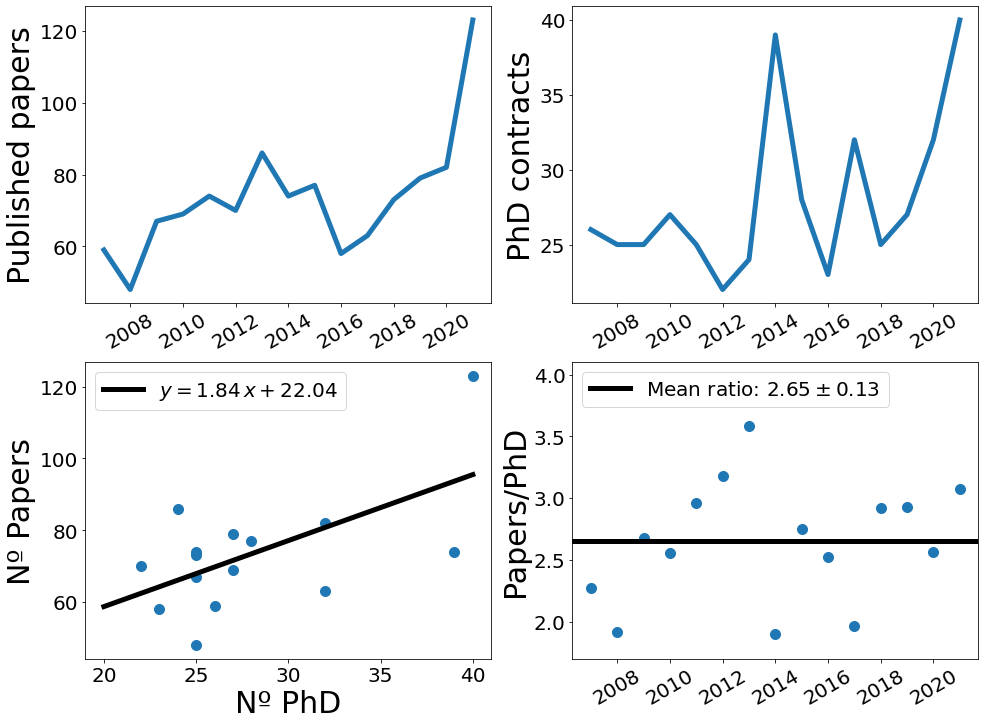

In [3]:
fig, ax = plt.subplot_mosaic("""AB
CD""", figsize=(8*2, 6*2))

#Papers in time
ax["A"].plot(time, papers, lw=5)

ax["A"].tick_params("x", rotation=30)
ax["A"].set_ylabel("Published papers")

#PhD in time
ax["B"].plot(time, PhD, lw=5)

ax["B"].tick_params("x", rotation=30)
ax["B"].set_ylabel("PhD contracts")


#Papers vs PhD
slope, intercept, r, p, se = linregress(PhD, papers)
x  = np.linspace(20, 40, 100)

ax["C"].scatter(PhD, papers, s=100)
ax["C"].plot(x, x*slope + intercept, lw=5, color='k', label=r"$y=%.2f\,x+%.2f$" % (slope, intercept))

ax["C"].set_xlabel("Nº PhD")
ax["C"].set_ylabel("Nº Papers")

ax["C"].legend()

#Papers/PhD ratio
ax["D"].scatter(time, papers/PhD, s=100)

mean_ratio = np.mean(papers/PhD)
std_err_ratio = np.std(papers/PhD, ddof=1) / np.sqrt(np.size(papers/PhD))

ax["D"].axhline([mean_ratio], color='k', lw=5, label="Mean ratio: $%.2f \pm %.2f$" % (mean_ratio, std_err_ratio))

ax["D"].set_ylabel("Papers/PhD")

ax["D"].tick_params("x", rotation=30)
ax["D"].set_ylim(1.7, 4.1)

ax["D"].legend(loc="upper left");

plt.savefig("IFISC_data_summary.png", dpi=300, bbox_inches='tight')

# CRA model 

In [4]:
N_PHD = 40
hour_price = 1200 / (37.5*4)
papers_phd_hour = 2.5 / (37.5*52)

p_w_2D = []

microwaves = np.arange(2, 7, 1)
PHDs = np.arange(10, 60, 0.01)

p_w_2D = np.zeros((len(microwaves), len(PHDs)))

m_w_2D = np.zeros((len(microwaves), len(PHDs)))

counter1 = -1
counter2 = 0

for M in microwaves:
    
    counter1 += 1
    counter2 = -1
    
    for PhD in PHDs:
        
        counter2 += 1

        λ = 1/(2.5/60) #Rate of PhD arrrival
        μ = 1/(3/60) #Inverse of microwave heating time

        p = λ / (μ*M) #Parameter

        P0 = compute_P0(λ, μ, p, M)

        t_cola = tiempo_medio_cola_CRA(λ, μ, p, M, P0)
        
        p_w = wasted_papers(t_cola, papers_phd_hour, PhD) * 210
        
        m_w = wasted_money(hour_price, t_cola, PhD) * 210

        p_w_2D[counter1, counter2] = p_w
        
        m_w_2D[counter1, counter2] = m_w

# OAO model 

In [5]:
microwaves_OAO = np.arange(2, 6, 0.02)
PHDs_OAO = np.arange(2, 30, 0.01)

p_w_2D_OAO = np.zeros((len(microwaves_OAO), len(PHDs_OAO)))
m_w_2D_OAO = np.zeros((len(microwaves_OAO), len(PHDs_OAO)))

counter1 = -1
counter2 = 0

t_h = 3/60

for M in microwaves_OAO:
    
    counter1 += 1
    counter2 = -1
    
    for PhD in PHDs_OAO:
        
        counter2 += 1

        t_cola = tiempo_medio_cola_OAO(PhD, M, t_h)
        
        p_w = wasted_papers(t_cola, papers_phd_hour, PhD) * 210
        m_w = wasted_money(hour_price, t_cola, PhD) * 210

        p_w_2D_OAO[counter1, counter2] = p_w
        m_w_2D_OAO[counter1, counter2] = m_w

# Figures models

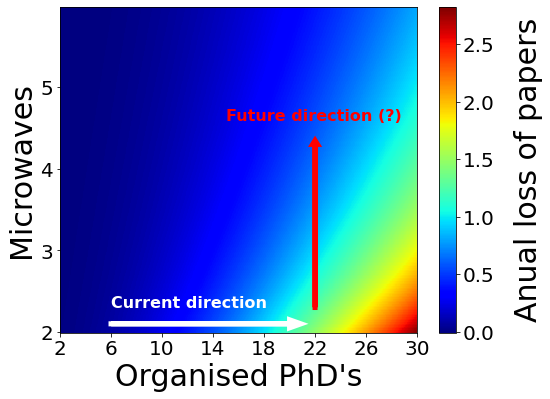

In [6]:
plt.plot(figsize=(8,6))

plt.pcolormesh(PHDs_OAO, microwaves_OAO, p_w_2D_OAO, cmap='jet', shading='nearest')

plt.arrow(6, 2.1, 14, 0, lw=5, color='w', head_width=0.1, head_length=0.9)
plt.text(6, 2.3, "Current direction", color="w", fontsize=16, weight="bold")

plt.arrow(22, 2.3, 0, 2, linewidth=5, color='r', head_width=0.4, head_length=0.05)
plt.text(15, 4.6, "Future direction (?)", color="r", weight="bold", fontsize=16, rotation=0)

plt.xlabel("Organised PhD's")
plt.ylabel("Microwaves")

plt.xticks(np.arange(2, 32, 4))

cbar = plt.colorbar()

cbar.set_label('Anual loss of papers', labelpad=20)

plt.savefig("SOM_model.png", dpi=300, bbox_inches='tight')

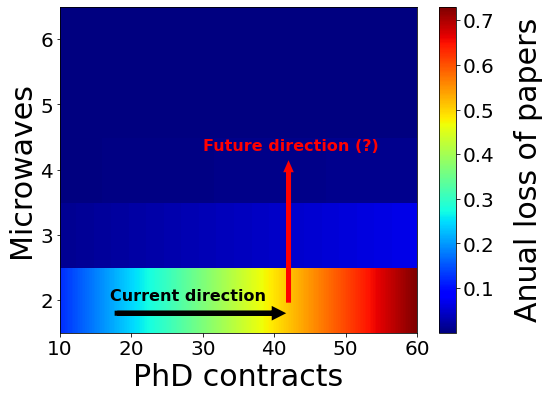

In [7]:
plt.plot(figsize=(8,6))

plt.pcolormesh(PHDs, microwaves, p_w_2D, cmap='jet', shading='nearest')

plt.arrow(18, 1.8, 22, 0, lw=5, color='k', head_width=0.1, head_length=0.9)
plt.text(17, 2.0, "Current direction", color="k", fontsize=16, weight="bold")

plt.arrow(42, 2, 0, 2, linewidth=5, color='r', head_width=0.4, head_length=0.05)
plt.text(30, 4.3, "Future direction (?)", color="r", weight="bold", fontsize=16, rotation=0)

plt.xlabel("PhD contracts")
plt.ylabel("Microwaves")

plt.xticks(np.arange(10, 70, 10))

cbar = plt.colorbar()

cbar.set_label('Anual loss of papers', labelpad=20)

plt.savefig("MSM_model.png", dpi=300, bbox_inches='tight')

# Data analysis

In [8]:
df = pd.read_csv("Data.csv")

for colname in df.columns:
    
    df[colname] = pd.to_datetime(df[colname])
    
df

,Entrada,Salida,Tiempo total,Entrada Micro,Salida Micro,Tiempo total micro,Dia,Inicio Cola,Fin Cola,Tiempo Cola
0,2022-03-17 12:45:00,2022-03-17 12:53:00,2022-03-17 00:08:00,2022-03-17 00:00:00,2022-03-17 00:03:49,2022-03-17 00:03:49,2022-03-03,NaT,NaT,NaT
1,2022-03-17 12:50:00,2022-03-17 12:53:00,2022-03-17 00:03:00,2022-03-17 00:01:43,2022-03-17 00:03:47,2022-03-17 00:02:04,2022-03-03,NaT,NaT,NaT
2,2022-03-17 12:50:00,2022-03-17 12:53:00,2022-03-17 00:03:00,2022-03-17 00:04:20,2022-03-17 00:07:04,2022-03-17 00:02:44,2022-03-03,NaT,NaT,NaT
3,2022-03-17 12:53:00,2022-03-17 12:56:00,2022-03-17 00:03:00,2022-03-17 00:11:28,2022-03-17 00:15:13,2022-03-17 00:03:45,2022-03-03,NaT,NaT,NaT
4,2022-03-17 12:59:00,2022-03-17 13:04:00,2022-03-17 00:05:00,2022-03-17 00:12:24,2022-03-17 00:15:42,2022-03-17 00:03:18,2022-03-03,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
104,NaT,NaT,NaT,2022-03-17 13:19:20,2022-03-17 13:21:48,2022-03-17 00:02:28,NaT,NaT,NaT,NaT
105,NaT,NaT,NaT,2022-03-17 13:20:55,2022-03-17 13:23:20,2022-03-17 00:02:25,NaT,NaT,NaT,NaT
106,NaT,NaT,NaT,2022-03-17 13:22:00,2022-03-17 13:24:40,2022-03-17 00:02:40,NaT,NaT,NaT,NaT
107,NaT,NaT,NaT,2022-03-17 13:23:28,2022-03-17 13:27:25,2022-03-17 00:03:57,NaT,NaT,NaT,NaT


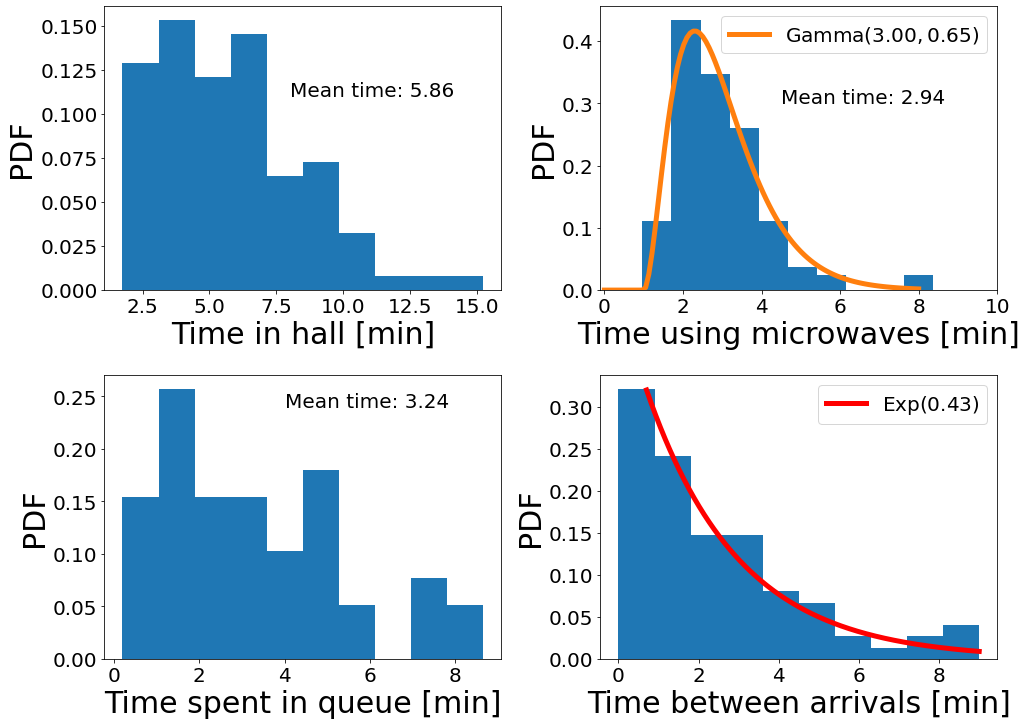

In [9]:
tiempo_total = [item.minute + item.second / 60.0 for item in df["Tiempo total"]]
tiempo_total_micro = [item.minute + item.second / 60.0 for item in df["Tiempo total micro"]]

tiempo_total_cola = [item.minute + item.second / 60.0 for item in df["Tiempo Cola"]]

interarrivals = []

for d in np.unique(df["Dia"]):

    interarrival = (df["Entrada"][df["Dia"] == d] - np.roll(df["Entrada"][df["Dia"]==d], 1))[1:]
    
    for item in interarrival:
    
        interarrivals.append(item.seconds / 60.0)

fig, ax = plt.subplot_mosaic("""AB
CD""", figsize=(8*2, 6*2))

ax["A"].hist(tiempo_total, bins=10, density=True)

ax["A"].set_ylabel("PDF")
ax["A"].set_xlabel("Time in hall [min]")
ax["A"].text(8, 0.11, "Mean time: %.2f" % np.nanmean(tiempo_total))

ax["B"].hist(tiempo_total_micro, bins=10, density=True);

ax["B"].set_ylabel("PDF")
ax["B"].set_xlabel("Time using microwaves [min]")
ax["B"].text(4.5, 0.3, "Mean time: %.2f" % np.nanmean(tiempo_total_micro))

x = np.arange(0, 9, 1)
x2 = np.linspace(0, 8, 100)

λ = 3.
θ = 0.65

#ax["B"].plot(x, poisson.pmf(x, 3), 'r-', lw=5, alpha=1, label="Poisson")
ax["B"].plot(x2, gamma.pdf(x2, λ, loc=1, scale=θ), color='C1', lw=5, alpha=1,
             label=r"Gamma$(%.2f, %.2f)$" % (λ, θ))

ax["B"].legend()
ax["B"].set_xlim(-0.1, 10)

ax["C"].hist(tiempo_total_cola, bins=10, density=True)

ax["C"].set_ylabel("PDF")
ax["C"].set_xlabel("Time spent in queue [min]")

ax["C"].text(4, 0.24, "Mean time: %.2f" % np.nanmean(tiempo_total_cola))

xx = np.linspace(0.7, 9, 1000)

λ = 1/np.nanmean(interarrivals)

ax["D"].hist(interarrivals, bins=10, density=True);
ax["D"].plot(xx, λ*np.exp(-λ*xx), lw=5, color="r", label=r"Exp$(%.2f)$" % λ)

ax["D"].set_ylabel("PDF")
ax["D"].set_xlabel("Time between arrivals [min]")
ax["D"].legend()

plt.subplots_adjust(hspace=0.3, wspace=0.25)

plt.savefig("data_analysis_experiments.png", dpi=300, bbox_inches='tight')

# Save data 

In [ ]:
#np.savetxt("papers_vs_microwaves_CRA.txt", )
#np.savetxt("money_vs_microwaves_CRA.txt", )
np.savetxt("papers_vs_microwaves_OAO.txt", np.transpose([microwaves_OAO, p_w_2D_OAO[:, 1300]]), header="#Microwaves\tPapers")
np.savetxt("money_vs_microwaves_OAO.txt", np.transpose([microwaves_OAO, m_w_2D_OAO[:, 1300]]), header="#Microwaves\tMoney");